# Engels Steenfabriek - Uncertainty Analysis

## Imports

In [52]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import RealParameter, CategoricalParameter, TimeSeriesOutcome, ScalarOutcome
from ema_workbench.analysis import prim, pairs_plotting
from ema_workbench.analysis.plotting import Density, multiple_densities
from ema_workbench.analysis.plotting_util import COLOR_LIST

# Set custom color list
COLOR_LIST = [
    "#1c33ff", "#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", "#a3ff19", "#19ffe8",
    "#e819ff", "#a5a7dd", "#565a8c", "#930700", "#2ade72"
]

import importlib
import utils

importlib.reload(utils)

<module 'utils' from 'c:\\Projects\\Revenue Scenarios\\BESS_Revenue_Scenarios\\Deep_Unc_Analysis\\utils.py'>

## Load Results if available (Alternative to Run Model)

In [24]:
results = utils.load_results_from_file("./model/outputs/experiments.tar.gz")
case_list = [
    "Case 1"
]

num_experiments = 50
num_policies = len(case_list)
x, o = results

[MainProcess/INFO] results loaded successfully from c:\Projects\Revenue Scenarios\Deep_Unc_Analysis\model\outputs\experiments.tar.gz


## Run model

In [47]:
model_file = "./250127 - BESS Financial Model Version 1.13 (revenue scenarios).xlsx"

case_list = [
    "Case 1"
]

num_policies = len(case_list) if len(case_list) > 1 else None

print(f"Number of policies: {num_policies}")

# generate a list from 1 to 345
revenue_scenario_list = [str(i) for i in range(1, 270)]
num_experiments = 50
num_policies = len(case_list)
model = utils.instantiate_model(model_file)

model.uncertainties = [
    # Cost Parameters
    # RealParameter("Contingency_CAPEX", -0.05, 0.1),
    # RealParameter("Contingency_OPEX", -0.05, 0.2),

    # Contract Type
    # RealParameter("MRI_Eneco", 162000, 400000),
    # RealParameter("Merchant_Revenue", 150000, 250000),
    # RealParameter("EnecoMRI", 150000, 350000)

    # Electrolyser Parameters
    # CategoricalParameter("sde_price_electrolyser", ("0.1136", "0.1308", "0.1479", "0.1651", "0.1880")),
    # RealParameter("degradation_factor", 0.001, 0.002),
    # CategoricalParameter("ppa_or_market_price", ("PPA as %% of EPEX-Spot", "Market Pricing")),

    # Revenue Scenarios
    # We include 1 as the baseline scenario with linear revenue growth
    # CategoricalParameter("forecast_scenario", tuple(revenue_scenario_list)),
    RealParameter("forecast_scenario", 1, 271)
    # Add Grid Costs as a categorical parameter
]

if num_policies > 1:
    model.levers = [
        CategoricalParameter("Case", (case_list))
    ]
else:
    model.levers = []

model.outcomes = [
    # Standard Metrics
    TimeSeriesOutcome("TIME"),
    ScalarOutcome("MODELCHECK"),
    
    # Debt Metrics
    #TimeSeriesOutcome("DSCR_Tenor"),
    #ScalarOutcome("DSCR_First5Years_Min"),
    #ScalarOutcome("ADSCR_First5Years"),
    #ScalarOutcome("ADSCR_Tenor"),
    #ScalarOutcome("LLCR"),
    #ScalarOutcome("LLCR_Min"),

    # IRR Metrics
    TimeSeriesOutcome("Rolling_Equity_IRR"),
    TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
    TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
    TimeSeriesOutcome("Forecast"),
    ScalarOutcome("Project_IRR_AfterTax"),
    ScalarOutcome("Project_IRR_BeforeTax"),
    ScalarOutcome("Equity_IRR"),
    ScalarOutcome("Forecast_Hyperparameter"),
    # NPV Metrics
    ScalarOutcome("Equity_NPV"),

    # Operational Metrics
    TimeSeriesOutcome("EBITDA"),

    # Hydrogen Electrolyser Metrics
    # ScalarOutcome("LCOH")
]

x, o = utils.run_experiments(model, num_experiments, num_policies = num_policies)
model.cleanup()

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments


Number of policies: None


[MainProcess/INFO] performing experiments sequentially
100%|██████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]
[MainProcess/INFO] experiments finished
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning:

still to be tested!!

[MainProcess/INFO] results saved successfully to c:\Projects\Revenue Scenarios\BESS_Revenue_Scenarios\Deep_Unc_Analysis\model\outputs\experiments.tar.gz


## Time Series Outcomes

### Rolling Equity Graphs and Animation

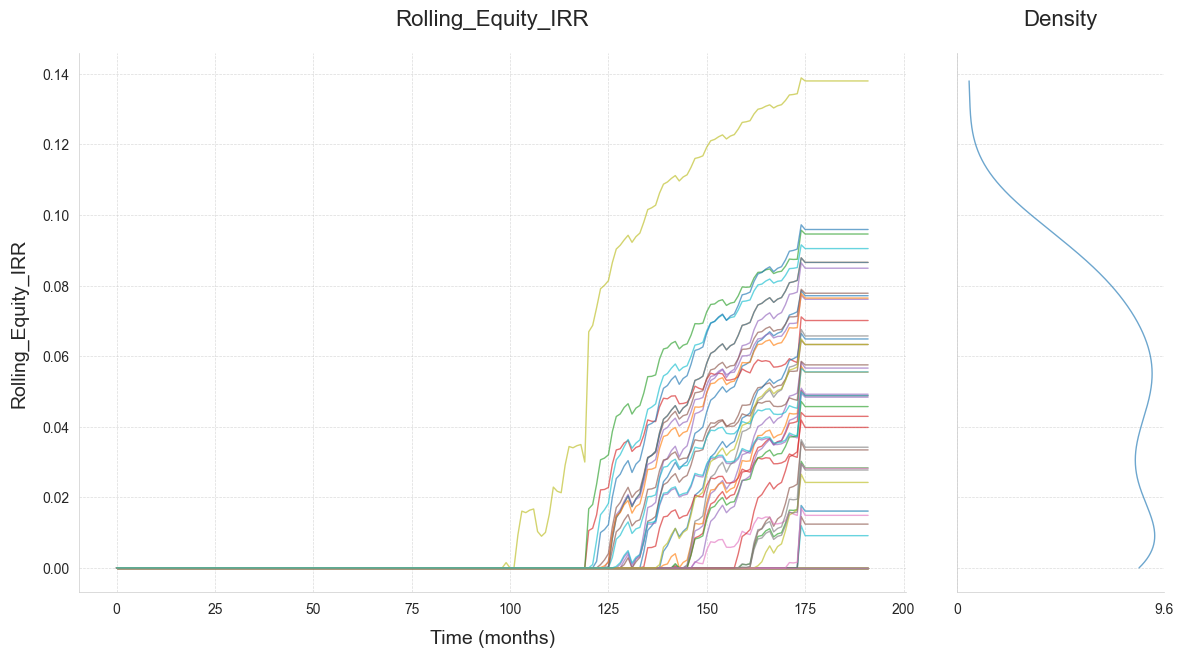

In [53]:
utils.create_line_graph(x, o, case_list, outcome_name = "Rolling_Equity_IRR")
# utils.create_animation(o)

### Unsure

In [ ]:
fig, axes = multiple_densities(x, o, legend=True, outcomes_to_show='EBITDA', points_in_time=[24,36,48,60,72], density=Density.KDE, fill=True)


# Set style to seaborn whitegrid for a clean look
sns.set_style('whitegrid')

# Update line properties
for axis in axes:
    for line in axis.get_lines():
        line.set_alpha(0.9)  # Slightly less transparent than before
        line.set_linewidth(1)  # Increase line width for better visibility
    axis.margins(y=0)

# Clean up spines and grid lines
for axis in axes:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_linewidth(0.5)
    axis.spines['bottom'].set_linewidth(0.5)
    axis.xaxis.set_tick_params(width=0.5)
    axis.yaxis.set_tick_params(width=0.5)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Light dashed grid lines

# Remove top and right spines, clean the look
sns.despine()

fig = plt.gcf()
fig.set_size_inches(20,10)
ax = fig.get_axes()

## Scalar Outcomes

### Electrolyser Model Validation
- Some plots for sanity check of electrolyser model and LCOH

In [ ]:
# Plot LCOH against Degradation
lcoh = o["LCOH"]
degradation = x['Case']

# Create scatter plot
plt.figure(figsize=(20, 6))
plt.scatter(degradation, lcoh, alpha=0.6, edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of LCOH vs Degradation of Electrolyser', fontsize=16)
plt.xlabel('Degradation of Electrolyser  (% / MWh H2)', fontsize=14)
plt.ylabel('LCOH (€ / kg H2)', fontsize=14)

# Show plot
plt.grid(True)
plt.show()

### KDE plot

In [49]:
utils.plot_npv_kde_by_case(o, num_experiments, num_policies, case_list)

### Boxplot

In [48]:
utils.plot_npv_boxplot(o, case_list)

[ 0.07714747 -0.16368574 -0.05916978  0.07011175  0.08493606  0.06331572
  0.01609687 -0.04271652 -0.01081932  0.01609687  0.06488303  0.08658483
  0.09462743 -0.02433642  0.05662771  0.07784781 -0.11856737 -0.06461186
  0.13801114  0.09049797  0.09590777 -0.03499443  0.02834027  0.04879471
  0.07612768  0.03343514  0.0281915   0.03420152 -0.07003828  0.00913394
 -0.0396403   0.05547463 -0.02887644  0.04294909  0.04839352  0.01240515
 -0.07564211  0.06573407  0.02422215  0.05554436  0.08658483  0.07648101
  0.04572085  0.03981372  0.04921931  0.05753935  0.0148902   0.02774477
  0.06331625  0.04881762]
['Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1'
 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1'
 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1'
 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1'
 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1' 'Case 1'
 'Case 1' 'Case 1' 'Case 

## PRIM analysis

### Model Check

In [54]:
y = (o["Equity_IRR"] > 0.35) 
#& (o["DSCR_First5Years_Min"] >= 1.0) & (o["ADSCR_First5Years"] >= 1.15)
# Run the PRIM algorithm
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()

fig = plt.gcf()
fig.set_size_inches(14,7)

AssertionError: 

In [55]:
# specify box of interest
boi = 25
box1.inspect(boi)
box1.inspect(boi, style='graph')

fig = plt.gcf()
fig.set_size_inches(18,6)

NameError: name 'box1' is not defined

In [56]:
box1.show_pairs_scatter(boi)

fig = plt.gcf()
fig.set_size_inches(16,12)

NameError: name 'box1' is not defined

## Model Behaviour Check

In [57]:
MC_values = np.array(o['MODELCHECK']).astype(float)

    # Create a DataFrame for better handling
dataMC = pd.DataFrame({'MODELCHECK': MC_values})

Validation_Analysis = pd.merge(x, dataMC, right_index=True, left_index=True)
filtered_df = Validation_Analysis[Validation_Analysis['MODELCHECK'] > 0]
filtered_df

,forecast_scenario,scenario,policy,model,MODELCHECK


## Parameter Sensitivity Test

In [58]:
fig, axes = pairs_plotting.pairs_scatter(x, o, group_by = "Case", legend = True)

fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = fig.get_axes()

KeyError: 'Case'

In [59]:
utils.rank_features_IRR(x, o)

InvalidParameterError: The 'max_features' parameter of ExtraTreesClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 0 instead.

## Plotly Test

In [60]:
default_font_fam = None  # use the streamlit standard font -> None
default_text_colour = "#333"  # dark grey
title_colour = "#000000"  # black
 
# define the Emmett Green 'huisstijl' template
template_emmett_green = {
    "height": 900,
    "width": 1800,
    "title": {
        "font": {"family": default_font_fam, "color": title_colour, "size": 30},
        "xanchor": "center",
        "yanchor": "middle",
        "y": 0.92,
        "x": 0.45,
    },
    "dragmode": "zoom",
    "colorway": [
        "#1c33ff",
        "#2ade72",
        "#ff6f1c",
        "#19ffe8",
        "#a3ff19",
        "#ff1930",
        "#ffb01c",
        "#e819ff",
        "#a5a7dd",
        "#565a8c",
        "#930700",
        "#7519ff",
    ],
    "hovermode": "x unified",
    "showlegend": True,
    "legend": {
        "x": 1.02,
        "y": 1.025,
        "yanchor": "top",
        "bgcolor": "#f7f7f7",
        "bordercolor": "#D0D0D0",
        "borderwidth": 0,
        "traceorder": "normal",
        "font": {"family": default_font_fam, "color": "#333", "size": 14},
    },
    "plot_bgcolor": "#f7f7f7",
    "paper_bgcolor": "#ffffff",
    "margin": {"l": 80, "t": 60, "b": 60, "r": 80},
    "yaxis": {
        "showspikes": True,
        "title": {"font": {"size": 16, "color": default_text_colour}},
        "tickfont": {"family": default_font_fam, "color": default_text_colour, "size": 14},
        "fixedrange": False,
    },
    "xaxis": {
        "title": {"font": {"size": 16, "color": default_text_colour}},
        "tickfont": {"family": default_font_fam, "color": default_text_colour, "size": 14},
 
    },
}

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def prepare_data(experiments, experiments_to_show, outcomes, outcomes_to_show, group_by, grouping_specifiers):
    time = outcomes['TIME'][0]  # Assuming the first row is representative
    if not outcomes_to_show:
        outcomes_to_show = list(outcomes.keys())
    return experiments, outcomes, outcomes_to_show, time, grouping_specifiers

def plotly_lines(
    experiments,
    outcomes,
    outcomes_to_show=[],
    group_by=None,
    grouping_specifiers=None,
    density="",
    legend=True,
    titles={},
    ylabels={},
    experiments_to_show=None,
    show_envelope=False,
    log=False,
):
    print("Generating line graph with Plotly")

    # Prepare the data
    data = prepare_data(
        experiments, experiments_to_show, outcomes, outcomes_to_show, group_by, grouping_specifiers
    )
    experiments, outcomes, outcomes_to_show, time, grouping_labels = data

    # Ensure time is properly formatted (assuming time is a numpy array)
    time = pd.Series(time).astype(float).to_list()

    # Create subplots
    cols = 2 if density else 1
    rows = len(outcomes_to_show)
    fig = make_subplots(rows=rows, cols=cols, shared_xaxes=True, subplot_titles=outcomes_to_show)

    # Define a color palette
    colors = [        "#1c33ff",
        "#2ade72",
        "#ff6f1c",
        "#19ffe8",
        "#a3ff19",
        "#ff1930",
        "#ffb01c",
        "#e819ff",
        "#a5a7dd",
        "#565a8c",
        "#930700",
        "#7519ff",]
    
    # Get unique cases
    unique_cases = experiments[group_by].unique()
    case_colors = {case: colors[i % len(colors)] for i, case in enumerate(unique_cases)}

    # Do the plotting
    for i, outcome_to_plot in enumerate(outcomes_to_show):
        row = i + 1
        # Line plot for each scenario
        for case in unique_cases:
            case_data = experiments[experiments[group_by] == case]
            for j in case_data.index:
                showlegend = j == case_data.index[0]  # Show legend only for the first line of each case
                fig.add_trace(
                    go.Scatter(x=time, y=outcomes[outcome_to_plot][j], mode='lines', name=case if showlegend else None, line=dict(color=case_colors[case])),
                    row=row, col=1
                )

        if density:
            # Add density plots here (e.g., histograms, KDEs, etc.)
            fig.add_trace(
                go.Histogram(x=outcomes[outcome_to_plot], name=outcome_to_plot + ' Density'),
                row=row, col=2
            )

        # Add titles and labels
        if outcome_to_plot in titles:
            fig.update_yaxes(title_text=titles[outcome_to_plot], row=row, col=1)
        if outcome_to_plot in ylabels:
            fig.update_yaxes(title_text=ylabels[outcome_to_plot], row=row, col=1)

    # Update layout for the entire figure
    fig.update_layout(
        #title="Line Plots with Plotly",
        legend_title="Cases",
        xaxis_title="Time",
        yaxis_title="Value",
    )

    fig.update_layout(**template_emmett_green)

    return fig

# Ensure outcomes_to_show is passed as a list
fig = plotly_lines(x, o, outcomes_to_show=['Rolling_Equity_IRR'], group_by='Case')
fig.show()


Generating line graph with Plotly


  2%|▊                                     | 1/50 [21:20<17:25:32, 1280.26s/it]


KeyError: 'Case'

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

def prepare_data(experiments, experiments_to_show, outcomes, outcomes_to_show, group_by, grouping_specifiers):
    time = outcomes['TIME'][0]  # Assuming the first row is representative
    if not outcomes_to_show:
        outcomes_to_show = list(outcomes.keys())
    return experiments, outcomes, outcomes_to_show, time, grouping_specifiers

def plotly_lines(
    experiments,
    outcomes,
    outcomes_to_show=[],
    group_by=None,
    grouping_specifiers=None,
    density="kde",
    legend=True,
    titles={},
    ylabels={},
    experiments_to_show=None,
    show_envelope=False,
    log=False,
):
    print("Generating line graph with Plotly")

    # Prepare the data
    data = prepare_data(
        experiments, experiments_to_show, outcomes, outcomes_to_show, group_by, grouping_specifiers
    )
    experiments, outcomes, outcomes_to_show, time, grouping_labels = data

    # Ensure time is properly formatted (assuming time is a numpy array)
    time = pd.Series(time).astype(float).to_list()

    # Create subplots
    cols = 2 if density else 1
    rows = len(outcomes_to_show)
    fig = make_subplots(rows=rows, cols=cols, shared_xaxes=True, subplot_titles=outcomes_to_show)

    # Define a color palette
    colors = [        "#1c33ff",
        "#2ade72",
        "#ff6f1c",
        "#19ffe8",
        "#a3ff19",
        "#ff1930",
        "#ffb01c",
        "#e819ff",
        "#a5a7dd",
        "#565a8c",
        "#930700",
        "#7519ff",]
    
    # Get unique cases
    unique_cases = experiments[group_by].unique()
    case_colors = {case: colors[i % len(colors)] for i, case in enumerate(unique_cases)}

    # Track which cases have been added to the legend
    case_in_legend = {case: False for case in unique_cases}

    # Do the plotting
    for i, outcome_to_plot in enumerate(outcomes_to_show):
        row = i + 1
        # Line plot for each scenario
        for case in unique_cases:
            case_data = experiments[experiments[group_by] == case]
            for j in case_data.index:
                showlegend = not case_in_legend[case]
                fig.add_trace(
                    go.Scatter(x=time, y=outcomes[outcome_to_plot][j], mode='lines', name=case if showlegend else None, line=dict(color=case_colors[case])),
                    row=row, col=1
                )
                if showlegend:
                    case_in_legend[case] = True

        if density:
            # Add density plots here (e.g., histograms, KDEs, etc.)
            if density == "histogram":
                fig.add_trace(
                    go.Histogram(x=outcomes[outcome_to_plot].flatten(), name=outcome_to_plot + ' Histogram', marker_color='blue'),
                    row=row, col=2
                )
            elif density == "kde":
                kde = gaussian_kde(outcomes[outcome_to_plot].flatten())
                x_vals = np.linspace(outcomes[outcome_to_plot].min(), outcomes[outcome_to_plot].max(), 100)
                y_vals = kde(x_vals)
                fig.add_trace(
                    go.Scatter(x=x_vals, y=y_vals, mode='lines', name=outcome_to_plot + ' KDE', line=dict(color='blue')),
                    row=row, col=2
                )

        # Add titles and labels
        if outcome_to_plot in titles:
            fig.update_yaxes(title_text=titles[outcome_to_plot], row=row, col=1)
        if outcome_to_plot in ylabels:
            fig.update_yaxes(title_text=ylabels[outcome_to_plot], row=row, col=1)

    # Update layout for the entire figure
    fig.update_layout(**template_emmett_green)

    return fig

# Ensure outcomes_to_show is passed as a list
fig = plotly_lines(x, o, outcomes_to_show=['Rolling_Equity_IRR'], group_by='Case', density="kde")
fig.show()

Generating line graph with Plotly


KeyError: 'Case'